<h1>TikTok Analysis - Part 2</h1>
<h2><i>Event Study</i></h2>
<h3>[2.1][Create Event Study Dataframe]</h3>

In [4]:
### Imports ###
import pandas as pd
import numpy as np
import pytz
from scipy import stats
import matplotlib.pyplot as plt

### Set necessary workspace variables ###
# Set execution type (to avoid repeating resource intensive operations)
RUN_TYPE = 0 # set to 0 to avoid file creation process
#RUN_TYPE = 1 # set to 1 to perform emotion analysis file creation process
#RUN_TYPE = 2 # set to 2 to perform topic analysis file creation process

# Define Ekman's emotions
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

# Timezones
eastern = pytz.timezone("US/Eastern")
european = pytz.timezone("Europe/Berlin")

In [5]:
### Read necessary dataframes, set index, and convert timezones ###
# Prep Videos
df_tesla = pd.read_csv('../data/tiktok/tiktok_emotions.csv').dropna()
df_tesla = df_tesla.drop(columns={'combined_text', 'combined_text_cleaned'}).rename(columns={
    'total_engagement': 'engagement',
    'combined_text_anger': 'anger',
    'combined_text_fear': 'fear',
    'combined_text_joy': 'joy',
    'combined_text_sadness': 'sadness',
    'combined_text_disgust': 'disgust',
    'combined_text_surprise': 'surprise',
    'combined_text_dominant_emotion': 'video_emotion'
})
df_tesla['timestamp'] = pd.to_datetime(df_tesla['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_tesla['timestamp'].dt.tz is None:
    df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_localize(eastern)
df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_convert(eastern)
df_tesla = df_tesla.set_index('timestamp').sort_index()

# Prep nyse data
df_nyse = (pd.read_csv('../data/stocks/tesla_nyse_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'volume'})
)
df_nyse['timestamp'] = pd.to_datetime(df_nyse['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_nyse['timestamp'].dt.tz is None:
    df_nyse['timestamp'] = df_nyse['timestamp'].dt.tz_localize(eastern)
df_nyse['timestamp'] = df_nyse['timestamp'].dt.tz_convert(eastern)
df_nyse = df_nyse.set_index('timestamp').sort_index()

# Prep xetra data
df_xetra = (pd.read_csv('../data/stocks/tesla_xetra_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'volume'})
)
df_xetra['timestamp'] = pd.to_datetime(df_xetra['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_xetra['timestamp'].dt.tz is None:
    df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_localize(european)
df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_convert(european)
df_xetra = df_xetra.set_index('timestamp').sort_index()

In [6]:
### Inspect dataframe ###
print("[Tesla]")
print("Datentyp der Spalte:", df_tesla.index.dtype)
print("Tesla Columns:", df_tesla.columns)
print("Number Videos:", len(df_tesla))

### Inspect dataframe ###
print("\n[NYSE]")
print("Datentyp der Spalte:", df_nyse.index.dtype)
print("Tesla Columns:" , df_nyse.columns)

### Inspect dataframe ###
print("\n[XETRA]")
print("Datentyp der Spalte:", df_xetra.index.dtype)
print("Tesla Columns:" , df_xetra.columns)

[Tesla]
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['engagement', 'anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise',
       'video_emotion'],
      dtype='object')
Number Videos: 326

[NYSE]
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['minute_of_day', 'log_return', 'log_volume', 'log_volume_z'], dtype='object')

[XETRA]
Datentyp der Spalte: datetime64[ns, Europe/Berlin]
Tesla Columns: Index(['minute_of_day', 'log_return', 'log_volume', 'log_volume_z'], dtype='object')


In [7]:
### Group Videos to events with dominant emotion ###
def compute_event_emotion(group):
    total_engagement = group['engagement'].sum()
    weighted_emo_scores = {
        emotion: (group[emotion] * group['engagement']).sum() / total_engagement
        for emotion in ekman_emotions
    }
    event_emotion = max(weighted_emo_scores, key=weighted_emo_scores.get)
    return pd.Series({
        **weighted_emo_scores,
        'event_emotion': event_emotion
    })

if not ('event_emotion' in df_tesla.columns):
    init_len = len(df_tesla)
    # 1. Filter out videos outside market hours
    df_tesla = df_tesla[
        df_tesla.index.time >= pd.to_datetime("04:00").time()
    ]
    df_tesla = df_tesla[
        df_tesla.index.time <= pd.to_datetime("18:59").time()
    ]

    # 2. Sort by time
    df_tesla.sort_index()

    # 3. Compute time difference between videos
    df_tesla['time_diff'] = df_tesla.index.diff()

    # 4. Cluster videos to events with time_diff >= 7h
    df_tesla['new_event'] = df_tesla['time_diff'] > pd.Timedelta(hours=7)

    # 5. Cumulate events in event_id
    df_tesla['event_id'] = df_tesla['new_event'].cumsum()

    # 6. Compute the dominant emotion for each event and merge back to df
    df_event_emotions = (df_tesla
        .drop(columns=['event_id'])
        .groupby(df_tesla['event_id'], group_keys=False)
        .apply(compute_event_emotion)
        .reset_index()
    )

    df_tesla = (df_tesla
        .reset_index()
        .merge(
            df_event_emotions[['event_id', 'event_emotion']],
            on='event_id',
            how='left'
        )
    )
    df_tesla = df_tesla[['timestamp', 'event_id', 'event_emotion']]

    # 7. Set event_time to time of the earliest video of the event (models from what point in time a reaction can occur)
    df_tesla['event_time'] = df_tesla.groupby('event_id')['timestamp'].transform('min')

    # 8. Filter duplicate events
    df_tesla = df_tesla.drop_duplicates(subset=['event_id']).set_index('event_time').sort_index()
    # 9. Show new length (plain events)
    new_len = len(df_tesla)
    rm_lines = init_len - new_len
    print("[Tesla]")
    print(f"[Info] Removed {rm_lines} tuples within events. New length (#videos): {new_len}")
    print("Datentyp der Spalte:", df_tesla.index.dtype)
    print("Tesla Columns:", df_tesla.columns)

[Tesla]
[Info] Removed 188 tuples within events. New length (#videos): 138
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['timestamp', 'event_id', 'event_emotion'], dtype='object')


In [8]:
### Create Event Study DataFrame (with actual, expected, abnormal return and volume ###
# 1. Filter events based on overlaps of estimation and event windows
# 2. Calculate expected and abnormal returns for each event
def filter_events(df_vid: pd.DataFrame, df_fin: pd.DataFrame, fin_tz: str, vid_tz: str = 'US/Eastern', get_pre: int = 0):
    # Define necessary vars
    est = 300
    obs = 180
    gap = est + obs
    results = []

    # 1. Filter by overlaps
    valid_events = []
    last_event = None

    # Add valid events to the list
    for date in df_vid.index:
        # First event always valid
        if last_event is None:
            valid_events.append(date)
            last_event = date
        else:
            # If timeshift > gaps, keep the current event and set as new last_event
            if (date - last_event) > pd.Timedelta(minutes=gap):
                valid_events.append(date)
                last_event = date

    # Only keep valid events
    df_vid = df_vid.loc[valid_events]
    print(f"[Overlap] New df_length: {len(df_vid)}")

    # 2. Align event_time with the next available trading timestamp
    # 2.1 Convert both their respective timezone if not yet set
    if df_vid.index.tz is None:
        df_vid.index = df_vid.index.tz_localize(vid_tz)
    elif df_vid.index.tz != vid_tz:
        df_vid.index = df_vid.index.tz_convert(vid_tz)

    # 2.2 Convert all timezones to utc (+00:00)
    df_vid.index = df_vid.index.tz_convert('UTC')
    df_fin.index = df_fin.index.tz_convert('UTC')

    # 2.3 Align vid and fin times
    for i, date in enumerate(df_vid.index):
        if date not in df_fin.index:
            future_times = df_fin.index[df_fin.index > date]
            if not future_times.empty:
                df_vid.index.values[i] = pd.Timestamp(future_times[0])

    # 3. Filter events without sufficient estimation_window data
    # 4. Filter events without sufficient event_window data
    valid_events = []

    for date in df_vid.index:
        day_data = df_fin[df_fin.index.date == date.date()]
        event_index = day_data.index.get_loc(date)

        remaining = len(day_data) - event_index

        if event_index >= est:
            if remaining >= obs:
                valid_events.append(date)

    df_vid = df_vid.loc[valid_events]
    print(f"[Sum Data] New df_length = {len(df_vid)}")

    # 5. Event study variables
    for event_row in df_vid.itertuples():
        event_id = event_row.event_id
        event_emo = event_row.event_emotion
        event_time = event_row.Index

        # 5.1 Compute estimation_ and event_window
        estimation_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=est) : event_time - pd.Timedelta(minutes=1)
        ]
        event_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=get_pre * est): event_time + pd.Timedelta(minutes=obs - 1)
        ]

        # 5.2 Compute expected values based on estimation window
        expected_return = estimation_window['log_return'].mean()
        expected_volume = estimation_window['log_volume'].median() # robust against outliers, see Bamber (1987)

        for i, fin_row in enumerate(event_window.itertuples()):
            if get_pre == 1:
                i = int((fin_row.Index - event_time).total_seconds() // 60)

            # 5.3 Compute actual and abnormal values
            actual_return = fin_row.log_return
            abnormal_return = actual_return - expected_return

            actual_volume = fin_row.log_volume
            abnormal_volume = actual_volume - expected_volume

            results.append({
                'event_id': event_id,
                'event_fin_offset': i,
                'event_time': event_time,
                'fin_time': fin_row.Index,
                'event_emo': event_emo,
                'actual_return': actual_return,
                'expected_return': expected_return,
                'abnormal_return': abnormal_return,
                'actual_volume': actual_volume,
                'expected_volume': expected_volume,
                'abnormal_volume': abnormal_volume
            })

    # 5.4 Make dataframe from results containing metrics
    df_valid_events = pd.DataFrame(results)

    return df_valid_events

In [9]:
### Create event_study and event_study_pre_post dataframes ###
if RUN_TYPE == 0:
    df_tesla = df_tesla[['event_id', 'event_emotion']] # index = event_time
    df_nyse = df_nyse[['log_return', 'log_volume']] # index = timestamp
    df_xetra = df_xetra[['log_return', 'log_volume']] # index = timestamp

    for df_stock_exchange, name in zip([df_nyse, df_xetra], ['nyse', 'xetra']):
        if name == 'df_nyse':
            fin_timezone = pytz.timezone("US/Eastern")
        else:
            fin_timezone = pytz.timezone("Europe/Berlin")

        # Create dfs (for inspection of results)
        df_event_study = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone)
        df_event_study_pre_post = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone, get_pre=1)

        # Saving as file
        df_event_study.to_csv(f'../data/tiktok/tiktok_{name}_event_study.csv')
        df_event_study_pre_post.to_csv(f'../data/tiktok/tiktok_{name}_event_study_pre_post')

        # Inspection of results
        print(f"[Info][{name}] Dataframe Inspection")
        print(f"Emotions: {df_event_study['event_emo'].unique()}")
        emotion = df_event_study['event_emo'].unique()
        for emo in emotion:
            print(f"  - {emo}: {len(df_event_study[df_event_study['event_emo'] == emo].groupby('event_id'))} events")

        print(f"\n[Info][{name}] Event Study DataFrame has {len(df_event_study)} entries.")
        print(f"[Info] Event Study Pre/Post DataFrame has {len(df_event_study_pre_post)} entries.\n")
        if (df_event_study_pre_post.columns == df_event_study.columns).all():
            print("[Info] emotion_event_study(_pre_post).csv files have the following columns:")
            print(df_event_study.columns.tolist())

[Overlap] New df_length: 137


C:\Users\aklei\AppData\Local\Temp\ipykernel_108904\1820614768.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  df_vid.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 68
[Overlap] New df_length: 137


C:\Users\aklei\AppData\Local\Temp\ipykernel_108904\1820614768.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  df_vid.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 68
[Info][nyse] Dataframe Inspection
Emotions: ['anger' 'fear' 'joy' 'sadness']
  - anger: 8 events
  - fear: 5 events
  - joy: 53 events
  - sadness: 2 events

[Info][nyse] Event Study DataFrame has 12240 entries.
[Info] Event Study Pre/Post DataFrame has 32640 entries.

[Info] emotion_event_study(_pre_post).csv files have the following columns:
['event_id', 'event_fin_offset', 'event_time', 'fin_time', 'event_emo', 'actual_return', 'expected_return', 'abnormal_return', 'actual_volume', 'expected_volume', 'abnormal_volume']
[Overlap] New df_length: 137


C:\Users\aklei\AppData\Local\Temp\ipykernel_108904\1820614768.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  df_vid.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 66
[Overlap] New df_length: 137


C:\Users\aklei\AppData\Local\Temp\ipykernel_108904\1820614768.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  df_vid.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 66
[Info][xetra] Dataframe Inspection
Emotions: ['anger' 'fear' 'joy' 'sadness']
  - anger: 8 events
  - fear: 5 events
  - joy: 52 events
  - sadness: 1 events

[Info][xetra] Event Study DataFrame has 11880 entries.
[Info] Event Study Pre/Post DataFrame has 31680 entries.

[Info] emotion_event_study(_pre_post).csv files have the following columns:
['event_id', 'event_fin_offset', 'event_time', 'fin_time', 'event_emo', 'actual_return', 'expected_return', 'abnormal_return', 'actual_volume', 'expected_volume', 'abnormal_volume']


<h3>[2.2][Event Study on Return]</h3>
<h4><u>2.2.1 Abnormal Return</u></h4>
<p>[Intro]</p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in stock return can be observed by the minute<br>
--> Is the mean abnormal return significantly greater / lower than 0 resp. does the mean abnormal return significantly differ from the expected return?</p>
<p>
    <ul>
        <li>H0: mean abnormal return = 0</li>
        <li>H1: mean abnormal return >< 0</li>
    </ul>
</p>

In [10]:
### Read event study dataframes ###
df_event_study_nyse = pd.read_csv('../data/tiktok/tiktok_nyse_event_study.csv')
df_event_study_nyse_pre_post = pd.read_csv('../data/tiktok/tiktok_nyse_event_study_pre_post')
df_event_study_xetra = pd.read_csv('../data/tiktok/tiktok_xetra_event_study.csv')
df_event_study_xetra_pre_post = pd.read_csv('../data/tiktok/tiktok_xetra_event_study_pre_post')

In [11]:
### Significance Testing of AR ###
# Variables
alpha = 0.05
nyse_res = pd.DataFrame()
xetra_res = pd.DataFrame()

# Functions
def stars(p):
    if p < 0.01: return '***'
    elif p < 0.05: return '**'
    elif p < 0.1: return '*'
    else: return ''

def test_abnormal_returns(df, test_col):
    results = []

    emotions = df['event_emo'].unique()
    minutes = df['event_fin_offset'].unique()

    for minute in minutes:
        row = {'minute': minute}

        for emo in emotions:
            values = df.loc[
                (df['event_fin_offset'] == minute) & (df['event_emo'] == emo),
                test_col
            ]
            if len(values) > 1:
                t_stat, p_value = stats.ttest_1samp(values, 0)
                row[f'{emo}_{test_col}_mean'] = values.mean()
                row[f'{emo}_{test_col}_t_stat'] = t_stat
                row[f'{emo}_{test_col}_p_value'] = p_value
                row[f'{emo}_{test_col}_sig'] = f"{t_stat:.2f}{stars(p_value)}" # adds stars
            else:
                row[f'{emo}_{test_col}_mean'] = np.nan
                row[f'{emo}_{test_col}_t_stat'] = np.nan
                row[f'{emo}_{test_col}_p_value'] = np.nan
                row[f'{emo}_{test_col}_sig'] = ''

        results.append(row)
    return pd.DataFrame(results)

for df_stock_exchange, name in zip([df_event_study_nyse, df_event_study_xetra], ['nyse', 'xetra']):
    ar_test_scores = test_abnormal_returns(df_stock_exchange, 'abnormal_return')
    ar_test_scores.set_index('minute', inplace=True)

    # Safe exchange specific results
    if name == 'nyse':
        nyse_res = ar_test_scores
    if name == 'xetra':
        xetra_res = ar_test_scores

In [12]:
nyse_res

,anger_abnormal_return_mean,anger_abnormal_return_t_stat,anger_abnormal_return_p_value,anger_abnormal_return_sig,fear_abnormal_return_mean,fear_abnormal_return_t_stat,fear_abnormal_return_p_value,fear_abnormal_return_sig,joy_abnormal_return_mean,joy_abnormal_return_t_stat,joy_abnormal_return_p_value,joy_abnormal_return_sig,sadness_abnormal_return_mean,sadness_abnormal_return_t_stat,sadness_abnormal_return_p_value,sadness_abnormal_return_sig
minute,,,,,,,,,,,,,,,,
0,0.000390,0.805643,0.446948,0.81,0.000592,1.267127,0.273861,1.27,-0.000219,-0.983431,0.329949,-0.98,-0.001007,-1.420696,0.390455,-1.42
1,-0.001099,-3.041256,0.018814,-3.04**,0.000134,0.855825,0.440332,0.86,0.000080,0.361131,0.719465,0.36,0.000281,1.396769,0.395559,1.40
2,0.000092,0.166541,0.872439,0.17,-0.000075,-0.124931,0.906605,-0.12,0.000041,0.255948,0.799001,0.26,-0.000072,-0.196863,0.876256,-0.20
3,-0.000282,-0.651992,0.535220,-0.65,-0.000450,-2.020469,0.113437,-2.02,-0.000030,-0.222963,0.824438,-0.22,0.000672,11.611378,0.054692,11.61*
4,0.000054,0.063486,0.951154,0.06,0.000537,1.873050,0.134356,1.87,0.000262,1.648458,0.105288,1.65,-0.000894,-4.024542,0.155044,-4.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.000167,-0.834173,0.431726,-0.83,-0.000781,-1.822656,0.142437,-1.82,-0.000077,-0.433877,0.666172,-0.43,-0.000138,-0.395053,0.760482,-0.40
176,0.000058,0.162436,0.875552,0.16,-0.000579,-0.824912,0.455774,-0.82,-0.000131,-0.764308,0.448138,-0.76,-0.000483,-0.904580,0.531868,-0.90
177,0.000390,0.970462,0.364146,0.97,-0.000088,-0.449691,0.676225,-0.45,-0.000105,-0.820652,0.415591,-0.82,0.000415,0.735276,0.596376,0.74


In [13]:
### Show exchange specific results ###
# Make list of p_value columns

for res, name in zip([nyse_res, xetra_res], ['nyse', 'xetra']):
    pval_cols = [col for col in res.columns if col.endswith('_p_value')]

    # Safe rows where at least one p-value is below alpha (significant)
    if name == 'nyse':
        nyse_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        nyse_sig_cols = [col for col in nyse_sig_rows.columns if col.endswith('_sig')]
    if name == 'xetra':
        xetra_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        xetra_sig_cols = [col for col in xetra_sig_rows.columns if col.endswith('_sig')]

print("[NYSE]\n", nyse_sig_rows[nyse_sig_cols])
print("\n[NYSE]\n", xetra_sig_rows[xetra_sig_cols])

[NYSE]
        anger_abnormal_return_sig fear_abnormal_return_sig  \
minute                                                      
1                        -3.04**                     0.86   
5                          -0.31                    -0.68   
15                          0.46                    -0.42   
17                         -1.28                     1.35   
20                         -0.30                  -3.80**   
21                         2.05*                    -1.16   
24                       -2.54**                     0.28   
27                       -2.84**                    -0.86   
41                         -0.72                    -1.50   
42                        2.83**                     1.19   
43                         -0.92                    -1.20   
47                         -1.47                    -0.17   
56                       -2.42**                     1.80   
65                        3.22**                     1.78   
73              

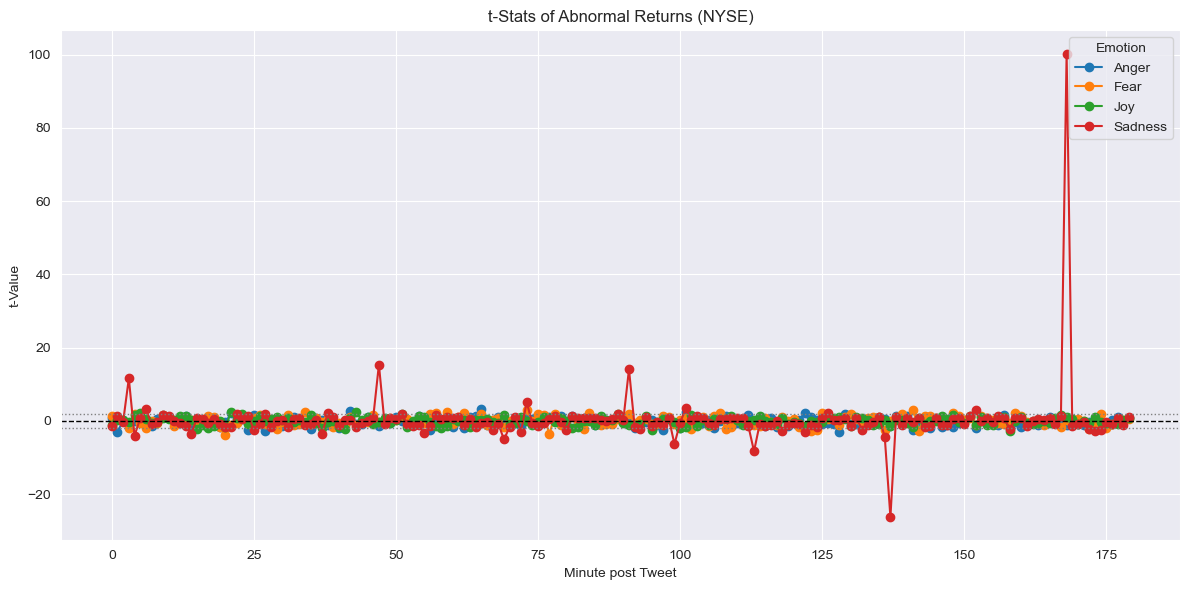

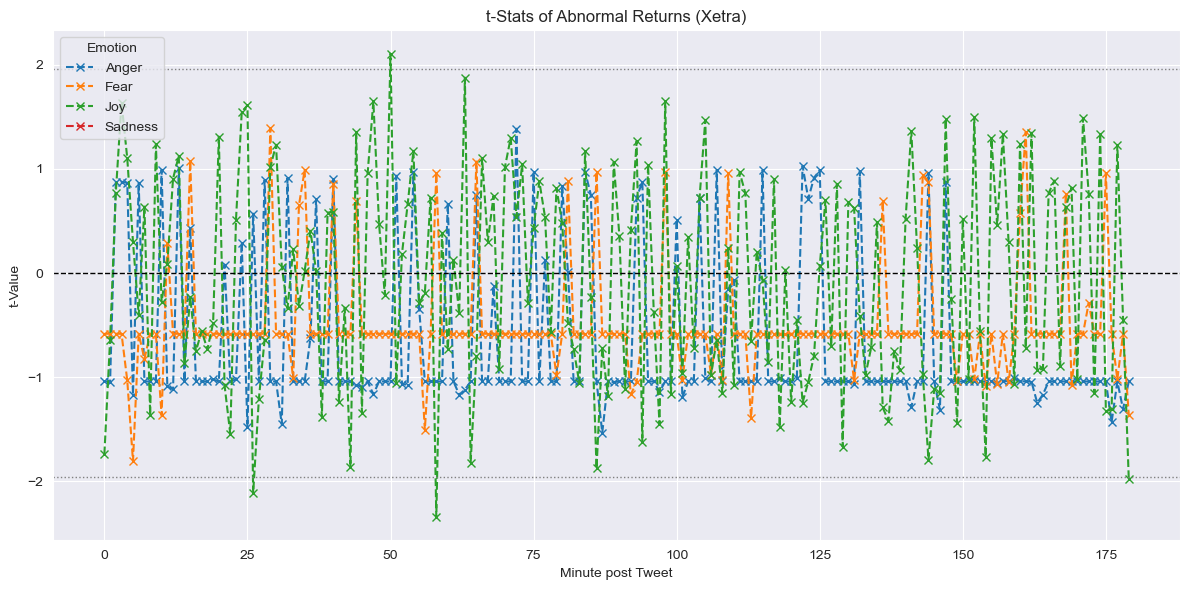

In [14]:
import matplotlib.pyplot as plt

# Emotionen aus den Spalten extrahieren (nehmen wir von NYSE)
t_stat_cols = [col for col in nyse_res.columns if col.endswith('_t_stat')]
emotions = [col.split('_')[0] for col in t_stat_cols]

# ---------- NYSE Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in nyse_res.columns:
        plt.plot(nyse_res.index, nyse_res[col], label=emo.capitalize(), linestyle='-', marker='o')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Stats of Abnormal Returns (NYSE)")
plt.xlabel("Minute post Tweet")
plt.ylabel("t-Value")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- XETRA Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in xetra_res.columns:
        plt.plot(xetra_res.index, xetra_res[col], label=emo.capitalize(), linestyle='--', marker='x')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Stats of Abnormal Returns (Xetra)")
plt.xlabel("Minute post Tweet")
plt.ylabel("t-Value")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()


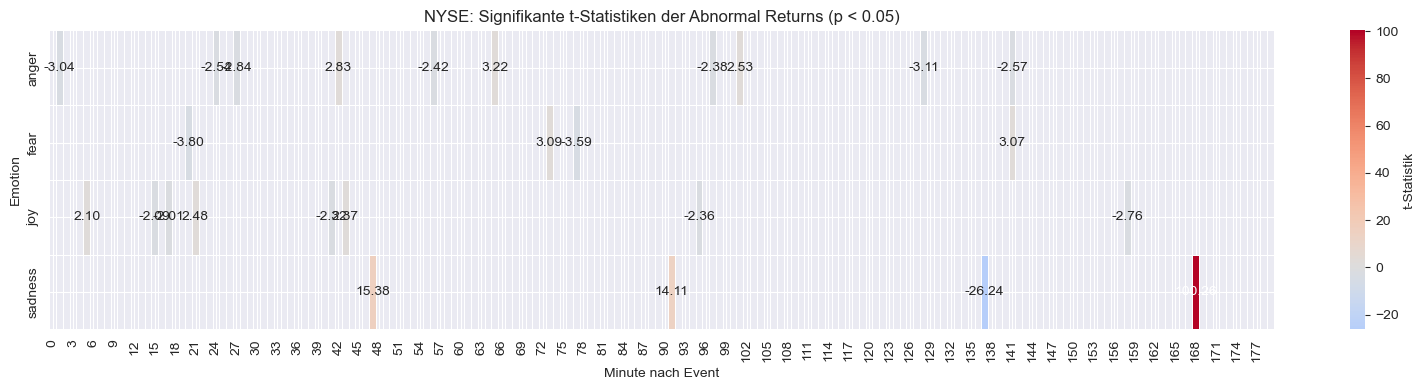

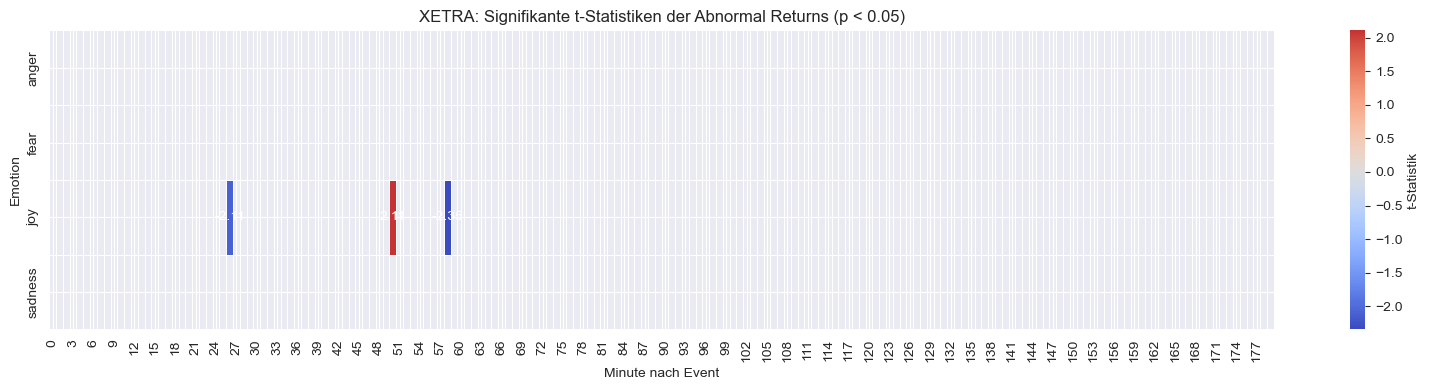

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmaps(nyse_res, xetra_res, alpha=0.05):
    def prepare_heatmap_data(res_df):
        # Nur Spalten mit "_abnormal_return_t_stat"
        emotions = [col.split('_')[0] for col in res_df.columns if col.endswith('_abnormal_return_t_stat')]

        heatmap_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_t_stat"] for emo in emotions
        }).T

        pvalue_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_p_value"] for emo in emotions
        }).T

        # Nur signifikante Werte behalten
        heatmap_data = heatmap_data.where(pvalue_data < alpha)

        return heatmap_data, emotions

    # Daten vorbereiten
    nyse_heatmap, _ = prepare_heatmap_data(nyse_res)
    xetra_heatmap, _ = prepare_heatmap_data(xetra_res)

    # Plot für NYSE
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        nyse_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=nyse_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute nach Event")
    plt.ylabel("Emotion")
    plt.title("NYSE: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

    # Plot für XETRA
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        xetra_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=xetra_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute nach Event")
    plt.ylabel("Emotion")
    plt.title("XETRA: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

# Aufruf
plot_heatmaps(nyse_res, xetra_res)

<h4><u>2.2.1 Cumulative Abnormal Return</u></h4>
<p>[Intro]</p>
<p>
    In the following it is analysed, whether an effect occurs within specified time windows. As log returns are additive, we can use the cumsum() Method to compute the cumulative sum and plot it over time. This way, we can yield a graph that shows the actual return over time and how the abnormal return deviates after the event.
</p>

#################################################################################################################

[Analysis][Info] Performing CAR/CAAR Analysis for nyse stock exchange

[Overall]

[Plot] Plotting cumulative log returns for overall events.
[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: -0.1806 %
.


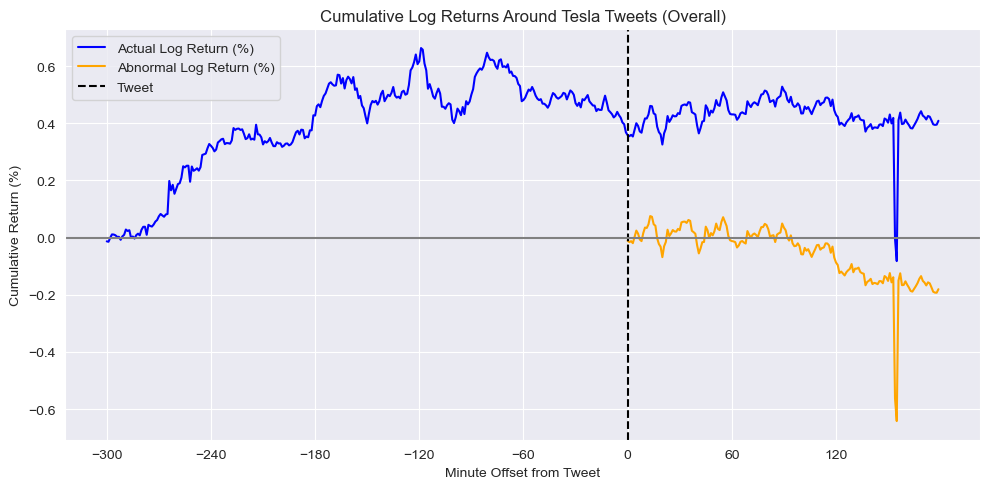

-----------------------------------------------------------------------------------------------------------------

[Emotions]

[Plot] Plotting cumulative log returns for emotion: anger
[Info] Cumulative Average Abnormal Return (CAAR) for anger over the event window: -0.7661 %



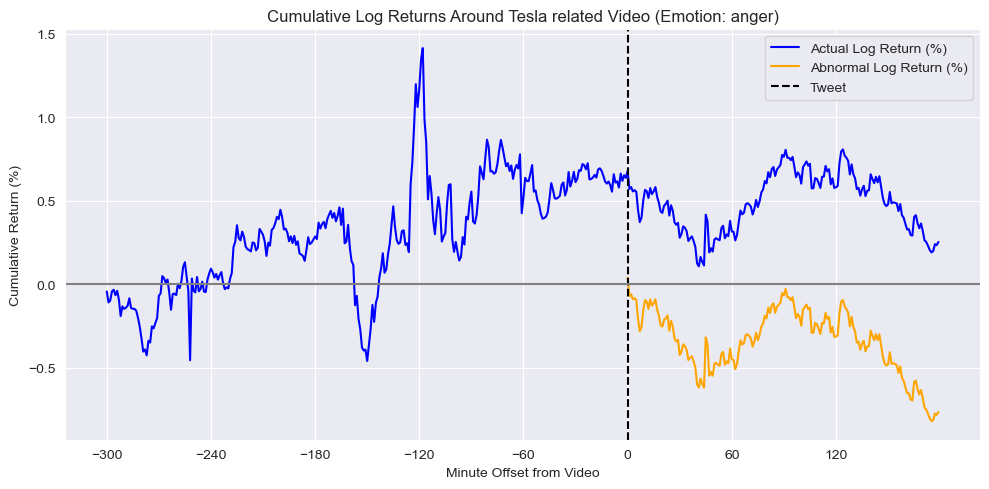

[Plot] Plotting cumulative log returns for emotion: fear
[Info] Cumulative Average Abnormal Return (CAAR) for fear over the event window: -0.2628 %



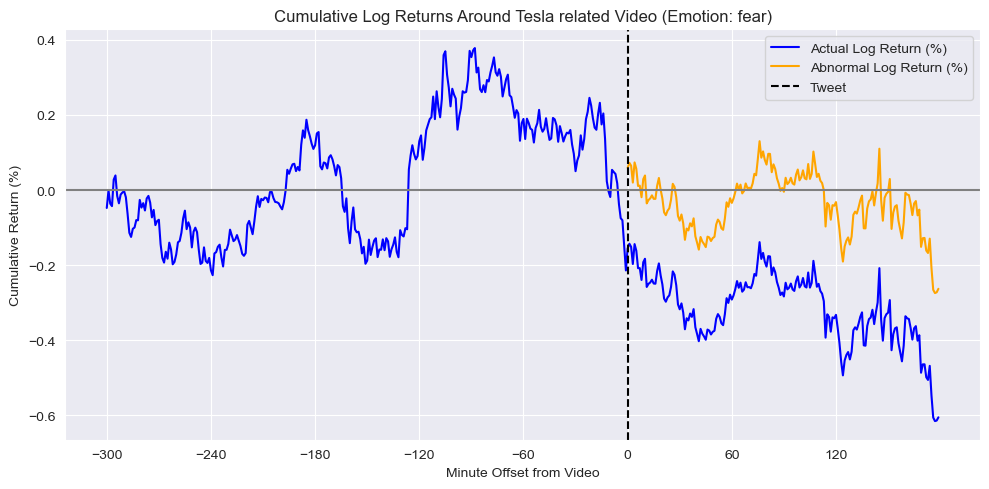

[Plot] Plotting cumulative log returns for emotion: joy
[Info] Cumulative Average Abnormal Return (CAAR) for joy over the event window: -0.0710 %



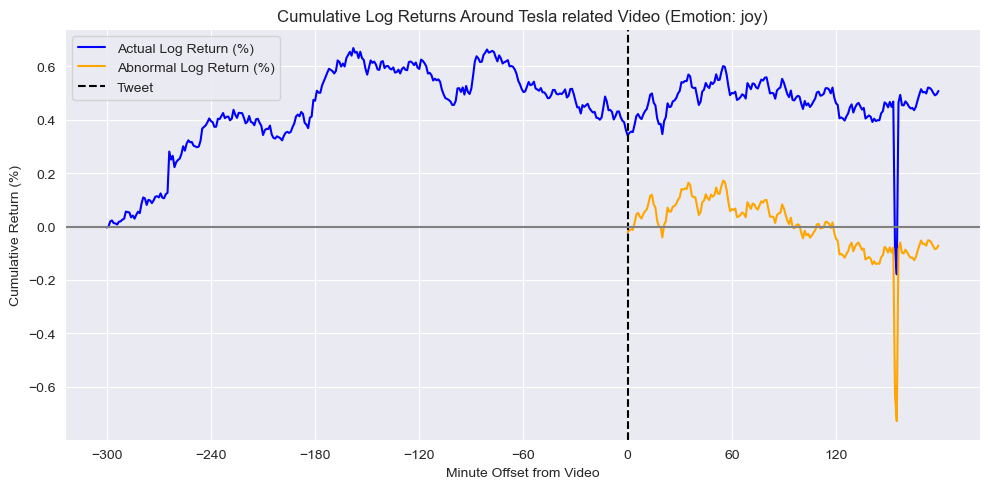

[Plot] Plotting cumulative log returns for emotion: sadness
[Info] Cumulative Average Abnormal Return (CAAR) for sadness over the event window: -0.5361 %



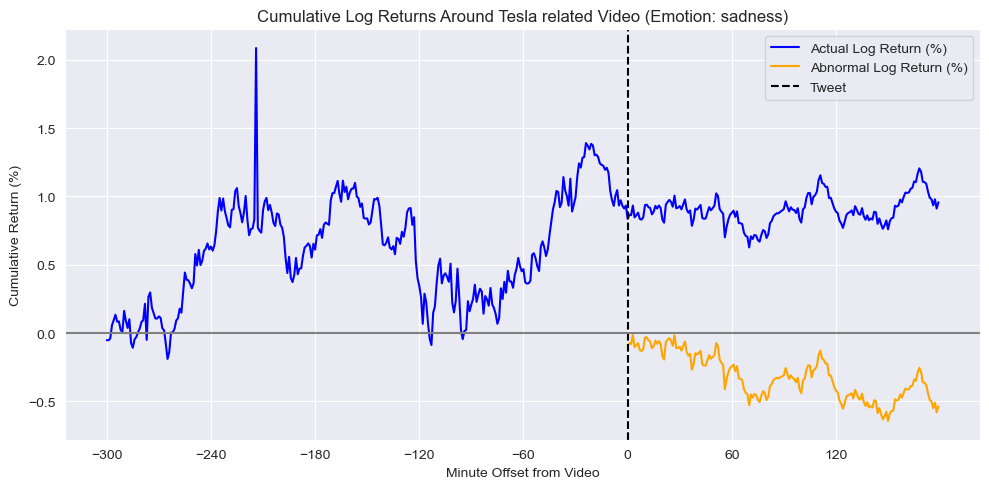

#################################################################################################################

[Analysis][Info] Performing CAR/CAAR Analysis for xetra stock exchange

[Overall]

[Plot] Plotting cumulative log returns for overall events.
[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: -0.2600 %
.


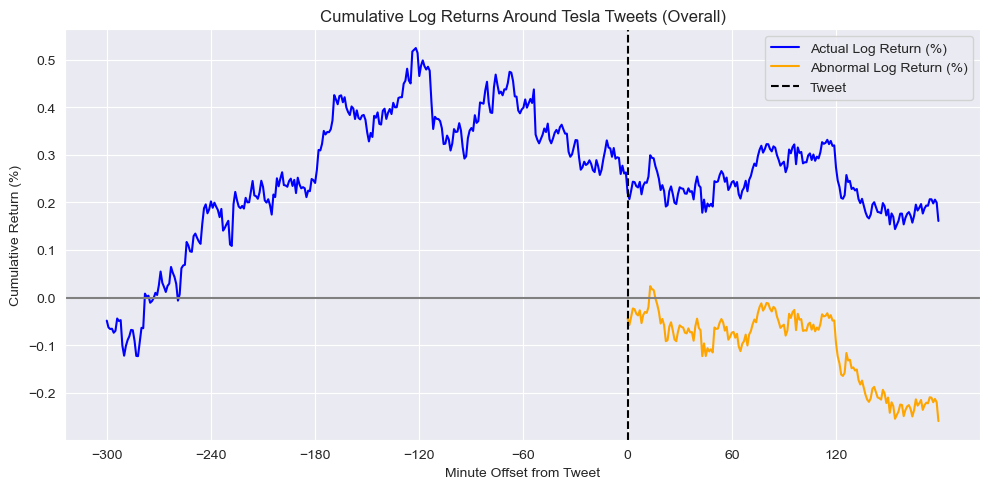

-----------------------------------------------------------------------------------------------------------------

[Emotions]

[Plot] Plotting cumulative log returns for emotion: anger
[Info] Cumulative Average Abnormal Return (CAAR) for anger over the event window: -0.6598 %



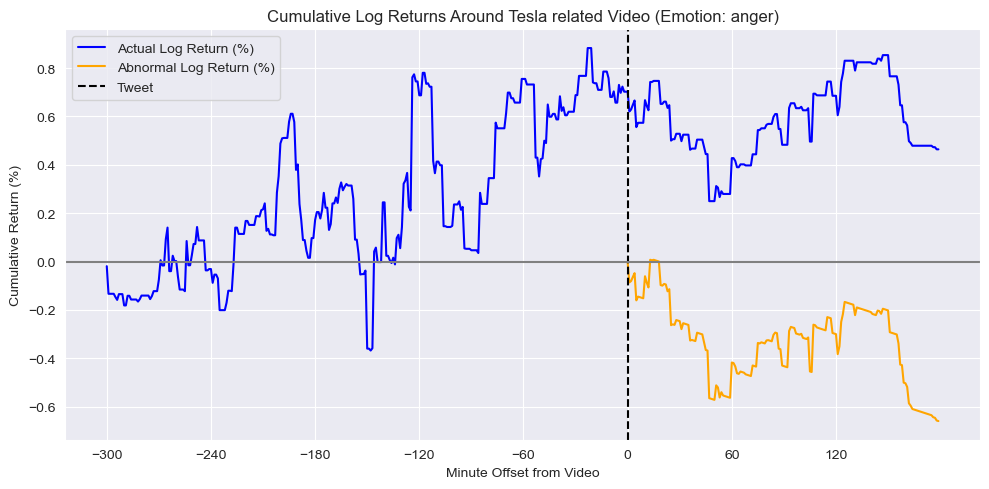

[Plot] Plotting cumulative log returns for emotion: fear
[Info] Cumulative Average Abnormal Return (CAAR) for fear over the event window: -0.8272 %



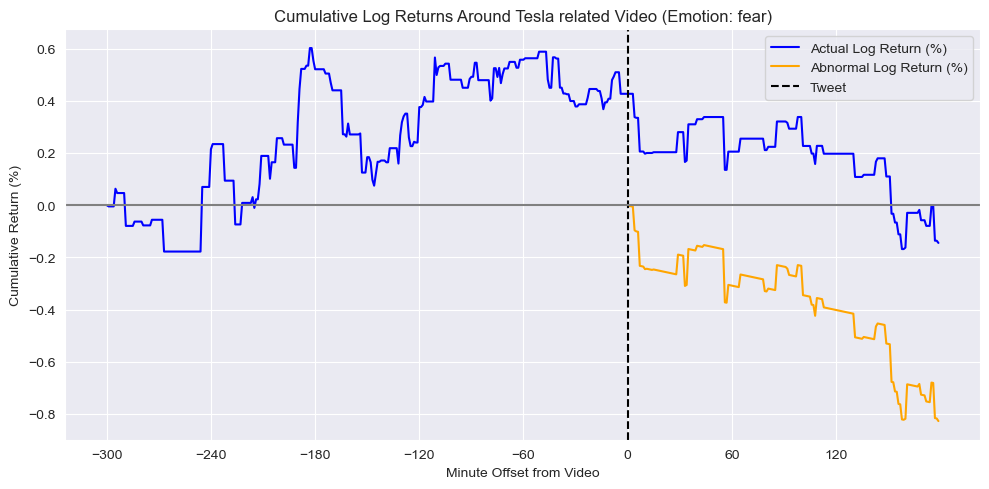

[Plot] Plotting cumulative log returns for emotion: joy
[Info] Cumulative Average Abnormal Return (CAAR) for joy over the event window: -0.1542 %



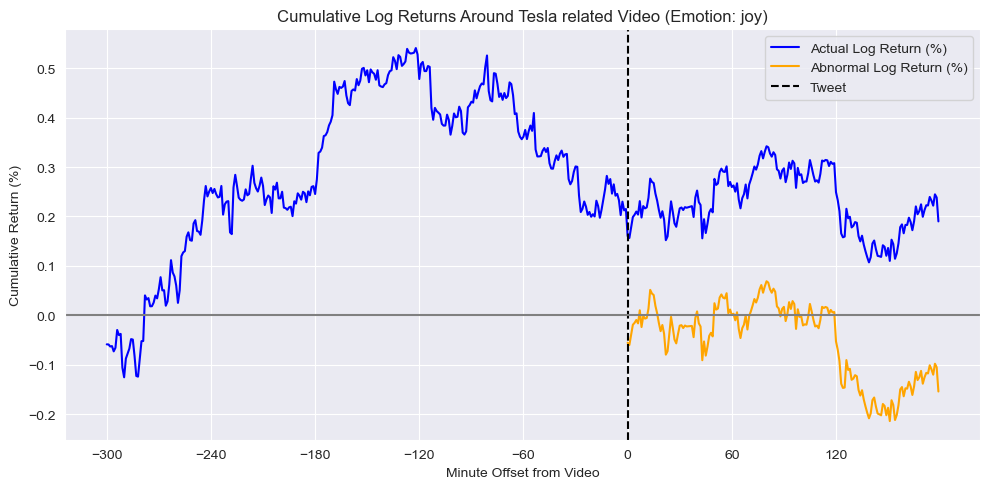

[Plot] Plotting cumulative log returns for emotion: sadness
[Info] Cumulative Average Abnormal Return (CAAR) for sadness over the event window: 0.2765 %



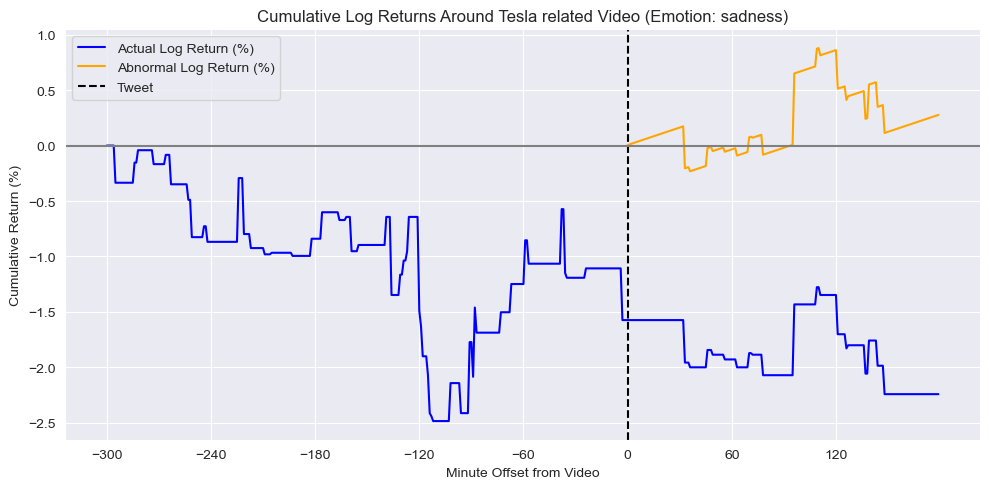

In [16]:
### [All emotions] Plotting Cumulative Log Returns Around Videos by Emotion ###

nyse_emotions = df_event_study_nyse_pre_post['event_emo'].unique()
xetra_emotions = df_event_study_xetra_pre_post['event_emo'].unique()

# Loop over two dataframes
for stock_exchange, name in zip([nyse_emotions, xetra_emotions], ['nyse', 'xetra']):
    print("#################################################################################################################\n")
    print(f'[Analysis][Info] Performing CAR/CAAR Analysis for {name} stock exchange\n')
    # Loop over emotions within dataframe
    if name == 'nyse':
        estimation_window = df_event_study_nyse_pre_post
        event_window = df_event_study_nyse_pre_post[df_event_study_nyse_pre_post['event_fin_offset'] >= 0]
    if name == 'xetra':
        estimation_window = df_event_study_xetra_pre_post
        event_window = df_event_study_xetra_pre_post[df_event_study_xetra_pre_post['event_fin_offset'] >= 0]

    for emo, i in zip(emotions, range(len(emotions))):
        # 0.5 Plot Overall Cumulative Log Returns Around Tweets
        if i == 0:
            actual_returns = estimation_window.groupby('event_fin_offset')['actual_return'].mean()
            cumulative_actual_return = actual_returns.cumsum()

            abnormal_returns = event_window.groupby('event_fin_offset')['abnormal_return'].mean()
            cumulative_abnormal_return = abnormal_returns.cumsum()

            caar = abnormal_returns.sum()
            print("[Overall]\n")
            print("[Plot] Plotting cumulative log returns for overall events.")
            print(f"[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: {caar * 100:.4f} %\n.")
            plt.figure(figsize=(10, 5))
            plt.plot(cumulative_actual_return.index, cumulative_actual_return.values * 100, label="Actual Log Return (%)", color="blue")
            plt.plot(cumulative_abnormal_return.index, cumulative_abnormal_return.values * 100, label="Abnormal Log Return (%)", color="orange")
            plt.axvline(0, linestyle="--", color="black", label="Tweet")
            plt.axhline(0, linestyle="-", color="gray")
            plt.title("Cumulative Log Returns Around Tesla Tweets (Overall)")
            plt.xlabel("Minute Offset from Tweet")
            plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
            plt.ylabel("Cumulative Return (%)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            print("-----------------------------------------------------------------------------------------------------------------\n")
            print("[Emotions]\n")

        # 1. Calculate cumulative actual log returns around tweets
        actual_returns = estimation_window[estimation_window['event_emo'] == emo].groupby('event_fin_offset')['actual_return'].mean()
        cumulative_actual_return = actual_returns.cumsum()

        # 2. Caluculate cumulative abnormal log returns around tweets
        abnormal_returns = event_window[event_window['event_emo'] == emo].groupby('event_fin_offset')['abnormal_return'].mean()
        cumulative_abnormal_return = abnormal_returns.cumsum()

        # 3. Plot
        # Print CAR over the event window
        caar = abnormal_returns.sum()  # Sum of mean abnormal returns over the event window (caar)
        print(f"[Plot] Plotting cumulative log returns for emotion: {emo}")
        print(f"[Info] Cumulative Average Abnormal Return (CAAR) for {emo} over the event window: {caar* 100:.4f} %\n")
        plt.figure(figsize=(10, 5))
        plt.plot(cumulative_actual_return.index, cumulative_actual_return.values * 100, label="Actual Log Return (%)", color="blue")
        plt.plot(cumulative_abnormal_return.index, cumulative_abnormal_return.values * 100, label="Abnormal Log Return (%)", color="orange")
        plt.axvline(0, linestyle="--", color="black", label="Tweet")
        plt.axhline(0, linestyle="-", color="gray")
        plt.title("Cumulative Log Returns Around Tesla related Video (Emotion: " + emo + ")")
        plt.xlabel("Minute Offset from Video")
        plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
        plt.ylabel("Cumulative Return (%)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [17]:
def test_car_significance(df: pd.DataFrame, se_emotions: np.ndarray):
    windows = [(0, 1), (0, 2), (0, 5), (0, 10), (0, 30), (0, 60), (0, 120)]
    results = []

    # First test overall effect (no emotion filter)
    for start, end in windows:
        window = df[
            (df['event_fin_offset'] >= start) &
            (df['event_fin_offset'] <= end)
        ]

        event_car = window.groupby('event_id')['abnormal_return'].sum()

        if len(event_car) > 1:  # Need at least 2 observations for t-test
            mean_car = event_car.mean()
            t_stat, p_value = stats.ttest_1samp(event_car, 0)
        else:
            mean_car = event_car.mean() if len(event_car) == 1 else np.nan
            t_stat, p_value = np.nan, np.nan

        results.append({
            'emotion': 'all',
            'window': f"[{start}, {end}]",
            'mean_car': f"{mean_car * 100:.4f} %" if not np.isnan(mean_car) else "NaN",
            't_stat': f"{round(t_stat, 2)}{stars(p_value)}" if not np.isnan(t_stat) else "NaN",
            'n_events': len(event_car)
        })

    # Then test for each emotion
    for se_emo in se_emotions:
        for start, end in windows:
            emo_window = df[
                (df['event_emo'] == se_emo) &
                (df['event_fin_offset'] >= start) &
                (df['event_fin_offset'] <= end)
            ]

            event_car = emo_window.groupby('event_id')['abnormal_return'].sum()

            if len(event_car) > 1:
                mean_car = event_car.mean()
                t_stat, p_value = stats.ttest_1samp(event_car, 0)
            else:
                mean_car = event_car.mean() if len(event_car) == 1 else np.nan
                t_stat, p_value = np.nan, np.nan

            results.append({
                'emotion': se_emo,
                'window': f"[{start}, {end}]",
                'mean_car': f"{mean_car * 100:.4f} %" if not np.isnan(mean_car) else "NaN",
                't_stat': f"{round(t_stat, 2)}{stars(p_value)}" if not np.isnan(t_stat) else "NaN",
                'n_events': len(event_car)
            })

    return pd.DataFrame(results)

# Ensure emotions are properly defined
nyse_emotions = [emo for emo in df_event_study_nyse['event_emo'].unique() if pd.notna(emo)]
xetra_emotions = [emo for emo in df_event_study_xetra['event_emo'].unique() if pd.notna(emo)]

df_nyse_car_results = test_car_significance(df_event_study_nyse, nyse_emotions)
df_xetra_car_results = test_car_significance(df_event_study_xetra, xetra_emotions)


In [18]:
### Print NYSE results ###
for emo in ['all'] + [e for e in df_nyse_car_results['emotion'].unique() if e != 'all']:
    if emo == 'all' or pd.notna(emo):
        print(f"\n[Info] Results for emotion '{emo}':")
        emo_results = df_nyse_car_results[df_nyse_car_results['emotion'] == emo]
        print(emo_results[['window', 'mean_car', 't_stat', 'n_events']])


[Info] Results for emotion 'all':
     window   mean_car t_stat  n_events
0    [0, 1]  -0.0159 %  -0.69        68
1    [0, 2]  -0.0124 %  -0.51        68
2    [0, 5]   0.0245 %   0.78        68
3   [0, 10]   0.0352 %    0.8        68
4   [0, 30]   0.0260 %   0.32        68
5   [0, 60]  -0.0121 %  -0.11        68
6  [0, 120]  -0.0871 %  -0.49        68

[Info] Results for emotion 'anger':
      window   mean_car t_stat  n_events
7     [0, 1]  -0.0709 %  -0.99         8
8     [0, 2]  -0.0616 %  -0.69         8
9     [0, 5]  -0.0968 %  -1.16         8
10   [0, 10]  -0.0955 %  -0.67         8
11   [0, 30]  -0.4242 %  -1.85         8
12   [0, 60]  -0.4507 %  -1.09         8
13  [0, 120]  -0.3130 %  -0.44         8

[Info] Results for emotion 'fear':
      window   mean_car t_stat  n_events
14    [0, 1]   0.0726 %   1.49         5
15    [0, 2]   0.0651 %   1.06         5
16    [0, 5]   0.0567 %   0.76         5
17   [0, 10]   0.0389 %   0.36         5
18   [0, 30]  -0.0814 %  -0.32         

<p>[Test-Results][NYSE]</p>
<p><i>What was tested?</i></p>
<p>For each emotion and specified timeframe in the post-event window it was tested if the cumulative abnormal return significantly deviates from 0. The goal was to detect whether there is a deviation from the expected return (H0: mean = 0).</p>
<p><i>Results</i></p>
<p>The stats show no significant effect of an emotion / of an event on the cumulative abnormal return. We can however observe trends
    <ul>
        <li>Overall events: Slightly positive CAR in the short term windows from 0-5 and 0-30 min post event.</li>
        <li>Joy: Similar to overall events (without emotions). No significant effects but positive trends in the windows between 0-5 and 0-30 min.</li>
        <li>Anger: Constant negative CARs with potential significant period for the 0-30 window. However, results are unreliable as we only have 8 events.</li>
    </ul>
</p>
<p><i>Conclusion</i></p>
<p>In the short-term and for individual points in time, we cannot prove a significant effect of any event (video) overall and with its corresponfing emotion whatsoever. Also, tests are not reliable because of the small sample sizes, especially for the emotions that are perceived negative. Overall / joy videos show a positive trend between 0-5 and 0-30 min post event windows.</p>

In [19]:
### Print NYSE results ###
for emo in ['all'] + [e for e in df_xetra_car_results['emotion'].unique() if e != 'all']:
    if emo == 'all' or pd.notna(emo):
        print(f"\n[Info] Results for emotion '{emo}':")
        emo_results = df_xetra_car_results[df_nyse_car_results['emotion'] == emo]
        print(emo_results[['window', 'mean_car', 't_stat', 'n_events']])


[Info] Results for emotion 'all':
     window   mean_car   t_stat  n_events
0    [0, 1]  -0.0579 %  -2.15**        66
1    [0, 2]  -0.0413 %    -1.18        66
2    [0, 5]  -0.0341 %    -0.71        66
3   [0, 10]  -0.0303 %    -0.48        66
4   [0, 30]  -0.0585 %    -0.54        66
5   [0, 60]  -0.0740 %    -0.59        66
6  [0, 120]  -0.0953 %    -0.53        66

[Info] Results for emotion 'anger':
      window   mean_car t_stat  n_events
7     [0, 1]  -0.0864 %  -1.09         8
8     [0, 2]  -0.0807 %  -1.02         8
9     [0, 5]  -0.1606 %  -1.33         8
10   [0, 10]  -0.0608 %   -0.7         8
11   [0, 30]  -0.2467 %  -0.93         8
12   [0, 60]  -0.4176 %  -1.16         8
13  [0, 120]  -0.3003 %  -0.45         8

[Info] Results for emotion 'fear':
      window   mean_car t_stat  n_events
14    [0, 1]  -0.0028 %  -0.58         5
15    [0, 2]  -0.0043 %  -0.58         5
16    [0, 5]  -0.1006 %   -1.2         5
17   [0, 10]  -0.2451 %  -1.79         5
18   [0, 30]  -0.1909 %

<p>[Test-Results][XETRA]</p>
<p><i>Results</i></p>
<p>The stats show no significant effect of an emotion / of an event on the cumulative abnormal return. We can however observe trends
    <ul>
        <li>Overall events: Significant negative reaction on the short term. Indicated an immediate negative market reaction.</li>
        <li>Anger: Consistent negative CARs. A trend toward significance can be estimated but sample size is too small to be certain.</li>
        <li>Joy: Observation is paradox because apparently joy leads to negative course reactions. Significance however only on the short term, fades out between 1-5 minutes.</li>
        <li>Sadness: Only one event, thus no testing possible and no statistical relevance.</li>
    </ul>
</p>
<p><i>Conclusion</i></p>
<p>In the short term we can observe a significant negative effect on the CAR in the frame of 0-1 min. Paradoxically, joy leads to a negative course reaction but this effect fades out quickly. Compared to the NYSE, immediate negative reactions are more harsh. Anger events have similar consequences.</p>

<p>[Test-Results][NYSE vs. XETRA]</p>
<p><i>Results</i></p>
<p>When comparing the two stock exchanges, we can observe some characteristics:
    <ul>
        <li>Market-wide effects: German investors react quicker than their american counterparts. There is however a paradox negative effect of events that are classified as joyful.</li>
        <li>Emotional differences:
            <ul>
                <li>Anger: in Xetra data we see an immediate drop, whereas in the Nyse data the drop is not as strong. German investors appear to react more impulsive.</li>
                <li>Fear: In US data, short term positve and in german data immediately negative.</li>
                <li>Joy: Neutral behaviour in America whereas it has a paradox negative effect in Germany.</li>
            </ul>
        <li>Joy: Observation is paradox because apparently joy leads to negative course reactions. Significance however only on the short term, fades out between 1-5 minutes.</li>
        <li>Sadness: Only one event, thus no testing possible and no statistical relevance.</li>
    </ul>
</p>
<p><i>Conclusion</i></p>
<p>In the short term we can observe a significant negative effect on the CAR in the frame of 0-1 min. Paradoxically, joy leads to a negative course reaction but this effect fades out quickly. Compared to the NYSE, immediate negative reactions are more harsh. Anger events have similar consequences.</p>

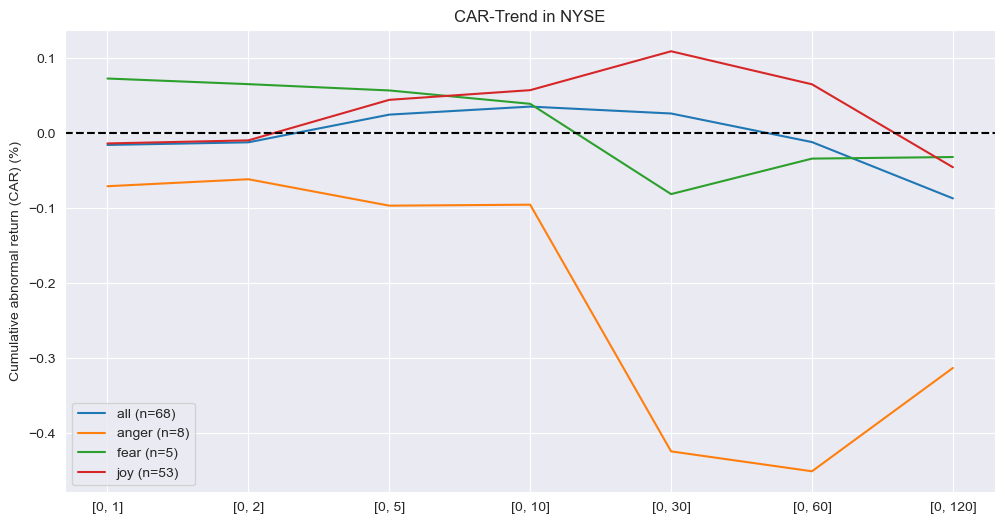

In [20]:
#### 1. Summary of significant effects (NYSE) ###
significant_results = df_nyse_car_results[
    (df_nyse_car_results['t_stat'].str.contains(r'\*\*', na=False)) |
    (df_nyse_car_results['t_stat'].str.contains(r'\*', na=False))
]

# 2. Visualisierung der CAR-Entwicklung
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for emotion in ['all', 'anger', 'fear', 'joy']:
    subset = df_nyse_car_results[df_nyse_car_results['emotion'] == emotion]
    plt.plot(subset['window'], subset['mean_car'].str.replace(' %','').astype(float),
             label=f"{emotion} (n={subset['n_events'].iloc[0]})")

plt.axhline(0, color='black', linestyle='--')
plt.title("CAR-Trend in NYSE")
plt.ylabel("Cumulative abnormal return (CAR) (%)")
plt.legend()
plt.show()

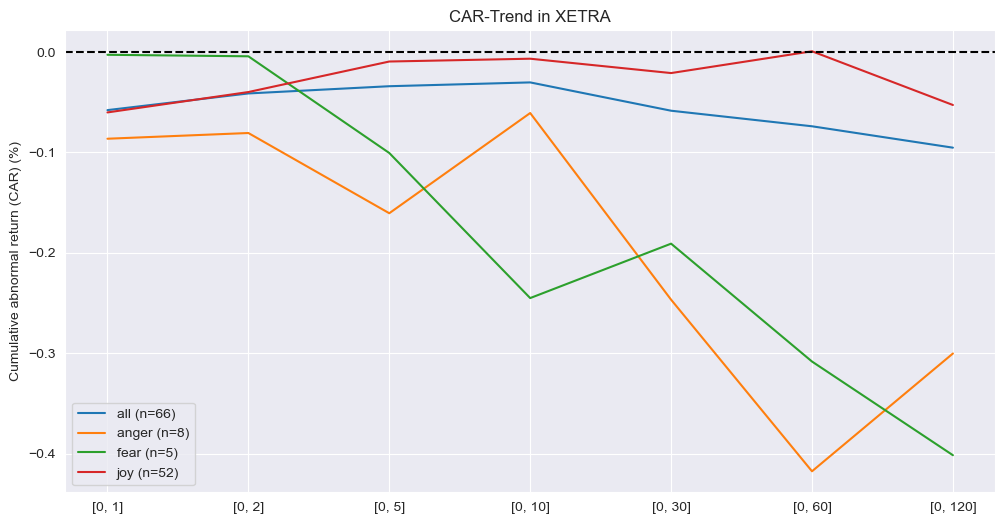

In [21]:
#### 2. Summary of significant effects (XETRA) ###
significant_results = df_xetra_car_results[
    (df_xetra_car_results['t_stat'].str.contains(r'\*\*', na=False)) |
    (df_xetra_car_results['t_stat'].str.contains(r'\*', na=False))
]

# 2. Visualisierung der CAR-Entwicklung
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for emotion in ['all', 'anger', 'fear', 'joy']:
    subset = df_xetra_car_results[df_xetra_car_results['emotion'] == emotion]
    plt.plot(subset['window'], subset['mean_car'].str.replace(' %','').astype(float),
             label=f"{emotion} (n={subset['n_events'].iloc[0]})")

plt.axhline(0, color='black', linestyle='--')
plt.title("CAR-Trend in XETRA")
plt.ylabel("Cumulative abnormal return (CAR) (%)")
plt.legend()
plt.show()